# XOR Proof of Concept.
## Basic estimation of the XOR function using the nonlinear regression network

In [360]:
%matplotlib ipympl

# Imports 
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
import torch 
import tqdm 

# Parameters
NUM_SAMPLES_TRAIN = 5000
NUM_SAMPLES_TEST = 500
MU = 1.99
ALPHA = -2.502807876 # universality constant

# Function Definitions
def xor(x: NDArray) -> int:
    if x[0] >= 0:
        # First or Fourth Quadrants
        if x[1] >= 0:
            # First Quadrant
            return 0
        # Fourth Quadrant
        else:
            return 1

    # Second or Third Quadrants
    else:
        # Second Quadrant
        if x[1] >= 0:
            return 1

        # Fourth Quadrant
        else:
            return 0
        
def generate_neuron_directions(input_dimension: int, width: int, sort=False) -> NDArray[np.floating]: 
    ''' Generate [width] neurons by uniformly sampling the [input_dimension] unit hypershpere'''
    neurons = torch.Tensor(input_dimension, width).normal_()
    neurons /=  torch.linalg.norm(neurons, axis=0)
    if sort:
        # sort by angle w.r.t x axis \
        sorted_idxs = torch.argsort(
                torch.arctan2(
                    neurons[1,:],
                    neurons[0,:]
                )
            )
    
        # sort the resulting array by the remaining angle w.r.t y axis 
        return neurons[:, sorted_idxs]
    
    return neurons

def generate_xor_samples(num_samples: int) -> tuple[torch.Tensor, torch.Tensor]:
    samples = torch.Tensor(2, num_samples).normal_()
    samples /= torch.linalg.norm(samples, axis=0)
    
    # Scale by radii distributed according to d^th root (where d is dimension) to get uniform density
    radii = torch.Tensor(samples.shape).uniform_(0.0, 1.0)
    samples *= torch.sqrt(radii)

    # Compute XOR,
    labels = torch.Tensor(np.expand_dims(
        np.array([xor(samples[:, i]) for i in range(num_samples)]), axis=-1
    ))
    
    return (
        samples, labels
        )
    
def plot_xor_samples(samples, labels, mask_incorrect = None, training=True): 
    mask_0 = (labels == 0).squeeze()
    mask_1 = (labels == 1).squeeze()
    plt.scatter(
        samples[0, mask_0],
        samples[1, mask_0],
        c="red",
        marker="x",
        label="XOR = 0",
    )
    plt.scatter(
        samples[0, mask_1],
        samples[1, mask_1],
        c="green",
        marker="o",
        label="XOR = 1",
    )

    if torch.any(mask_incorrect):
        plt.scatter(
            samples[:mask_incorrect][0,:],
            samples[:mask_incorrect][1,:],
            marker="+",
            c="yellow",
        )

    plt.axis("equal")
    plt.axvline(x=0, c="black")
    plt.axhline(y=0, c="black")

    plt.title(f"XOR Function Samples ({'Training' if training else 'Test'} Data)")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()
    plt.show()

def compute_activations(
    neurons: NDArray[np.floating],
    input_x: NDArray[np.floating],
    depth: int,
    renormalize: bool = False,
    reshape: bool = True
) -> torch.Tensor:

    _, width = neurons.shape
    _, num_samples= input_x.shape
    activations = torch.zeros(num_samples, width, depth, dtype=torch.float)
    activations[:, :, 0] = input_x.T @ neurons
    
    for idx_layer in range(1, depth):
        arr = activations[:, :, idx_layer - 1]
        
        # tent function 
        if renormalize:
            activations[:, :, idx_layer] =  (-ALPHA) *  torch.where(
                arr > 0,
                MU * (1 - (  - arr / ALPHA)),
                MU * (1 + (  - arr / ALPHA)),
            )   
        else:
            activations[:, :, idx_layer] = torch.where(
                arr > 0,
                MU * (1 - arr ),
                MU * (1 + arr ),
            )        
    if reshape:
        return activations.reshape((num_samples, depth * width))
    else: 
        return activations
def eval(acts, decoder, labels): 
    probs = acts @ decoder
    probs[probs < 0.5] = 0
    probs[probs >= 0.5] = 1
    acc = 100 * torch.sum(probs == labels) / len(probs) 
    return acc, probs

def compute_decoder(acts, labels, regularize = None) -> NDArray[np.floating]:
    return torch.linalg.lstsq(
        acts.T @ acts if not regularize else acts.T @ acts + regularize * torch.eye(acts.shape[1]),
        acts.T @ labels
    )[0]
    


def run_trial(width, depth, regularize=None):
    # Genenerate neurons, samples & train decoder
    samples_train, labels_train = generate_xor_samples(NUM_SAMPLES_TRAIN)    
    samples_test, labels_test = generate_xor_samples(NUM_SAMPLES_TEST)
    neurons = generate_neuron_directions(2, width) 
    acts_train = compute_activations(neurons, samples_train, depth)
    
    decoder = compute_decoder(acts_train, labels_train, regularize)
    # Eval Train Performance
    acc_train, _ = eval(acts_train, decoder, labels_train)

    # Eval Test Performance 
    acts_test = compute_activations(neurons, samples_test, depth)
    acc_test, _ = eval(acts_test, decoder, labels_test)
    
    return acc_train, acc_test
    

In [361]:
width = 100
depth = 50
acc_train, acc_test = run_trial(width, depth)
print(f"training accuracy: {acc_train}% ")
print(f"test accuracy: {acc_test}% ")

training accuracy: 97.81999969482422% 
test accuracy: 97.5999984741211% 


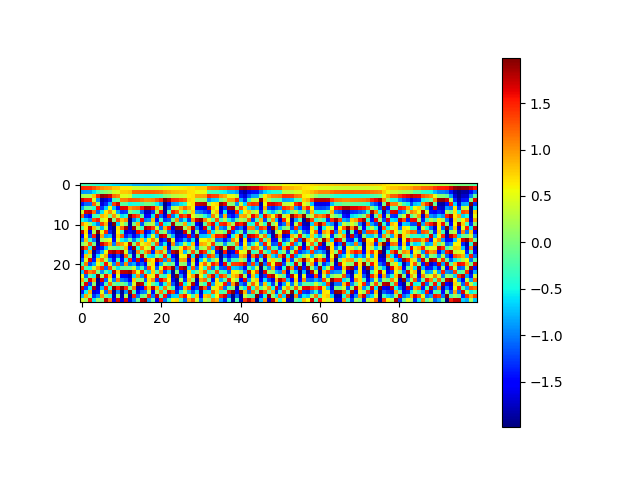

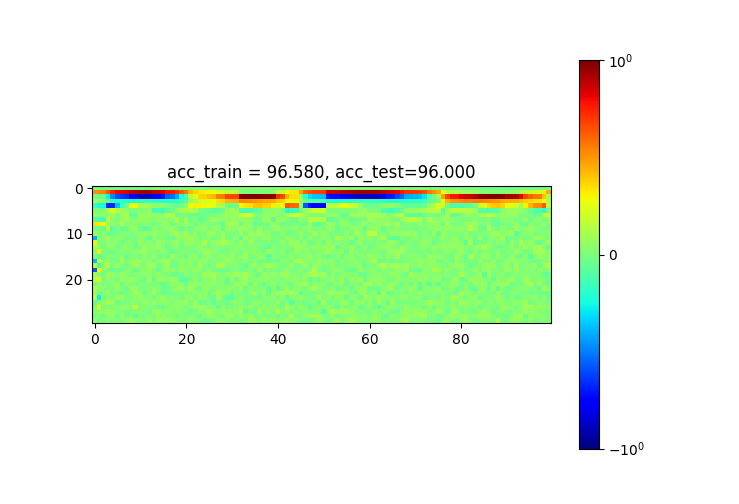

In [362]:
width = 100
depth = 30
samples, labels = generate_xor_samples(NUM_SAMPLES_TRAIN)   
neurons = generate_neuron_directions(2, width, sort=True) 
acts = compute_activations(neurons, samples, depth, reshape=False)
decoder = compute_decoder(acts.reshape(NUM_SAMPLES_TRAIN, width * depth), labels, regularize=.1)
acc_train, probs = eval(acts.reshape(NUM_SAMPLES_TRAIN, depth * width), decoder, labels)

samples_test, labels_test = generate_xor_samples(NUM_SAMPLES_TEST)
acts_test = compute_activations(neurons, samples_test, depth)
acc_test, _ = eval(acts_test, decoder, labels_test)
acc_test

plt.figure('acts deep look')
plt.clf()
plt.imshow(acts[0,...].T, cmap='jet', vmax=MU, vmin=-MU)
plt.colorbar()
plt.show()

plt.figure('decoder deep look')
plt.clf()
decoder_norm =decoder.reshape(width, depth).T / decoder.max() 
plt.imshow(decoder_norm, vmax=1, vmin=-1, cmap='jet', norm='symlog')
plt.colorbar()
plt.title(f'acc_train = {acc_train:.3f}, acc_test={acc_test:.3f}')
plt.show()



In [ ]:
# widths = torch.logspace(start=0, end=2.5, base=10, steps=30, dtype=torch.int)
# depths = torch.logspace(start=0, end=2.5, base=10, steps=30, dtype=torch.int)

num_trials = 1

widths = torch.linspace(start=1, end=100, steps=30, dtype=torch.int)
depths = torch.linspace(start=1, end=100, steps=30, dtype=torch.int)

accs_train = torch.zeros(len(widths), len(depths), num_trials)
accs_test = torch.zeros_like(accs_train)

for idx_trial in range(num_trials):
    for idx_width, width in tqdm.tqdm(
        iterable=enumerate(widths),
        total=len(widths),
        desc='Computing Widths...'
    ):
        for idx_depth, depth in tqdm.tqdm(
            iterable=enumerate(depths),
            total=len(depths),
            desc='Computing Depths...',
            leave=False,
        ):
            acc_train, acc_test = run_trial(width, depth) 
            accs_train[idx_width, idx_depth, idx_trial] = acc_train
            accs_test[idx_width, idx_depth, idx_trial] = acc_test

Trials...:   0%|          | 0/1 [00:00<?, ?it/s]































































































































































































































































































































































































































/tmp/ipykernel_796/1000007774.py:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(accs_train.mean(axis=-1), extent=(left, right, bottom, top), cmap='jet' )


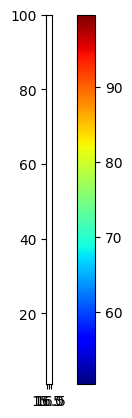

In [77]:
%matplotlib inline
fig = plt.figure(1)
plt.clf()
left, right = widths.min(), widths.max()
bottom, top = depths.min(), depths.max()
# ax = fig.add_subplot(111, projection='3d')
# X, Y = np.meshgrid(depths, widths)
# plt.xscale('log')
# plt.yscale('log')
# ax.plot_surface(X, Y, accs_train, cmap='jet')
plt.imshow(accs_train.mean(axis=-1), extent=(left, right, bottom, top), cmap='jet' )
plt.colorbar()

plt.show()

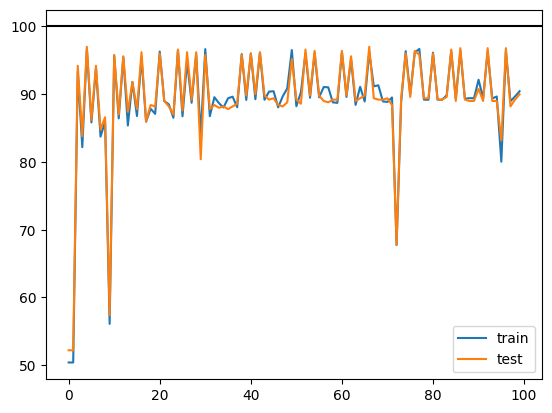

In [82]:
fig = plt.figure(2)
plt.clf()
plt.axhline(y=100,c='k')
plt.plot(accs_train.mean(axis=-1)[-1,:], label='train')
plt.plot(accs_test.mean(axis=-1)[-1,:], label='test')
# plt.errorbar(range(len(widths)), accs_train.mean(axis=-1)[-1,:],accs_train.std(axis=-1)[-1,:] / (num_trials**.5))
plt.legend()
plt.show()

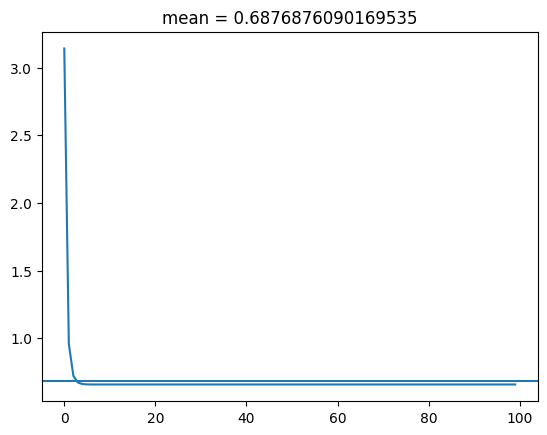

In [ ]:
sigmoids = []
def sigmoid(x):
    return 1/(1 + np.exp(-x))
    
curr = np.pi
for j in range(100):
    sigmoids.append(curr)
    curr = sigmoid(curr)
plt.plot(sigmoids)
plt.axhline(y=np.mean(sigmoids))
plt.title(f"mean = {np.mean(sigmoids)}")
plt.show()